In [19]:
import numpy as np 
import pandas as pd
data = pd.read_csv('final_data.csv')
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_value_sum,payment_types,payment_installments_max,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,4.0,500.0,19.0,8.0,13.0,38.71,credit_card|voucher,1.0,4.0,"Não testei o produto ainda, mas ele veio corre..."
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,1.0,400.0,19.0,13.0,19.0,141.46,boleto,1.0,4.0,Muito bom o produto.
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,1.0,420.0,24.0,19.0,21.0,179.12,credit_card,3.0,5.0,NaN
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,3.0,450.0,30.0,10.0,20.0,72.20,credit_card,1.0,5.0,O produto foi exatamente o que eu esperava e e...
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,4.0,250.0,51.0,15.0,15.0,28.62,credit_card,1.0,5.0,NaN


In [20]:
data.shape
data['customer_id'].value_counts()

customer_id
fc3d1daec319d62d49bfb5e1f83123e9    21
bd5d39761aa56689a265d95d8d32b8be    20
be1b70680b9f9694d8c70f41fa3dc92b    20
adb32467ecc74b53576d9d13a5a55891    15
10de381f8a8d23fff822753305f71cae    15
                                    ..
4b63383d57d7b45e8c7df93cdbc5029d     1
3b84c81b13c1c7278b099793e720998f     1
1a66bf0ca8926c664ad542e9d551805d     1
226b95c7c8f8587f805a7c0c809e5170     1
edb027a75a1449115f6b43211ae02a24     1
Name: count, Length: 99441, dtype: int64

In [21]:
#so clearly customer id is not unique lets remove it (run this cell(done) )
data = data.drop(columns = ['customer_id'])

In [22]:
# So first lets sort based on customer unique id and order_purchase_stamp
data = data.sort_values(['customer_unique_id','order_purchase_timestamp']).reset_index(drop = True)

In [23]:
# there is no use of order_id 
data = data.drop(columns =['order_id'] )

In [24]:
counts = data['order_status'].value_counts()
proportions = data['order_status'].value_counts(normalize=True)
proportions

order_status
delivered      0.971541
shipped        0.010456
canceled       0.006224
unavailable    0.005378
invoiced       0.003183
processing     0.003147
created        0.000044
approved       0.000026
Name: proportion, dtype: float64

In [25]:
counts_dict = data['order_status'].value_counts().to_dict()
proportions_dict = data['order_status'].value_counts(normalize=True).to_dict()

In [26]:
# so yup one hot is the goto but we are building a unsupervised model so distace is measured so lets use behavioural features 
# instead of just one hot  
data['pct_orders_delivered'] = (
    data.groupby('customer_unique_id')['order_status']
        .transform(lambda x: (x == 'delivered').mean())
)

data['pct_orders_canceled'] = (
    data.groupby('customer_unique_id')['order_status']
        .transform(lambda x: (x == 'canceled').mean())
)

data['pct_orders_unavailable'] = (
    data.groupby('customer_unique_id')['order_status']
        .transform(lambda x: (x == 'unavailable').mean())
)

data['order_failure_rate'] = (
    data['pct_orders_canceled'] + data['pct_orders_unavailable']
)

data['order_completion_rate'] = data['pct_orders_delivered']


In [27]:
# removing the parent column (order_status)
data = data.drop(columns = ['order_status'])


In [28]:
# handling reviews
data['has_review_comment'] = data['review_comment_message'].notna().astype(int)

data['review_length'] = (
    data['review_comment_message']
        .fillna("")
        .str.len()
)

In [29]:
# droppping reviews 
data = data.drop(columns = 'review_comment_message')
data.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,...,payment_types,payment_installments_max,review_score,pct_orders_delivered,pct_orders_canceled,pct_orders_unavailable,order_failure_rate,order_completion_rate,has_review_comment,review_length
0,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21 00:00:00,0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,1.0,...,credit_card,8.0,5.0,1.0,0.0,0.0,0.0,1.0,1,111
1,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15 00:00:00,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,1.0,...,credit_card,1.0,4.0,1.0,0.0,0.0,0.0,1.0,0,0
2,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,2017-04-07 00:00:00,0000f46a3911fa3c0805444483337064,88115,sao jose,SC,1.0,...,credit_card,8.0,3.0,1.0,0.0,0.0,0.0,1.0,0,0
3,2017-10-12 20:29:41,2017-10-12 20:49:17,2017-10-13 20:08:19,2017-11-01 21:23:05,2017-11-13 00:00:00,0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA,1.0,...,credit_card,4.0,4.0,1.0,0.0,0.0,0.0,1.0,1,12
4,2017-11-14 19:45:42,2017-11-14 20:06:52,2017-11-16 19:52:10,2017-11-27 23:08:56,2017-12-05 00:00:00,0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP,1.0,...,credit_card,6.0,5.0,1.0,0.0,0.0,0.0,1.0,0,0


In [30]:
data['payment_types'].value_counts()

payment_types
credit_card               84442
boleto                    23037
credit_card|voucher        2506
voucher                    1737
debit_card                 1696
not_defined                   3
credit_card|debit_card        1
Name: count, dtype: int64

In [31]:
# cant one hot encode so even though we lose info this is the only option 
data['num_payment_types'] = data['payment_types'].fillna("").apply(
    lambda x: len(x.split("|")) if x else 0
)


In [32]:
data = data.drop(columns = ['payment_types'])

In [33]:
# we already have zip codes showing closeness so ya remove customer_city
data = data.drop(columns = ['customer_city'])

In [34]:
# now dealling with cunstomer_unique_id and product_id 
#see clealry both of their use is now not needed as
#we have product_category_name also 
#we made the maximal use of customer id already so first lets drop 
#prouduct_id and keep customer one for further use 
data = data.drop(columns = ['product_category_name' ,'order_item_id','seller_id'])

In [ ]:
data = data.drop(columns = ['customer_state ','product_id' ])

In [36]:
data = data.drop(columns = ['customer_zip_code_prefix'])

In [37]:
data = data.drop(columns = ['product_id'])

In [38]:
# freight_value captures operational cost imposed by a customer
# so keep it 
#data = data.drop(columns = ['customer_unique_id'])

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_purchase_timestamp       113425 non-null  object 
 1   order_approved_at              113264 non-null  object 
 2   order_delivered_carrier_date   111457 non-null  object 
 3   order_delivered_customer_date  110196 non-null  object 
 4   order_estimated_delivery_date  113425 non-null  object 
 5   customer_unique_id             113425 non-null  object 
 6   customer_state                 113425 non-null  object 
 7   shipping_limit_date            112650 non-null  object 
 8   price                          113425 non-null  float64
 9   freight_value                  113425 non-null  float64
 10  product_name_lenght            111047 non-null  float64
 11  product_description_lenght     111047 non-null  float64
 12  product_photos_qty            

In [40]:
# the golden rule in unsupervised feature selection 
"""If a column only answers “which one?” and not “how much / how often / 
how intense?”, it does NOT belong in unsupervised modeling."""

'If a column only answers “which one?” and not “how much / how often / \nhow intense?”, it does NOT belong in unsupervised modeling.'

In [41]:
# dealing with date and time in unsupervised learining 
# the thing that matters in unsupervised learing is distance so we do not keep the raw time 
# stamps but will introduce meaning suitable features for the model

In [42]:
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date"
]

for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors="coerce")
data["purchase_hour"] = data["order_purchase_timestamp"].dt.hour

data["is_weekend"] = (
    data["order_purchase_timestamp"].dt.weekday >= 5
).astype(int)
data["approval_delay_hours"] = (
    (data["order_approved_at"] - data["order_purchase_timestamp"])
    .dt.total_seconds() / 3600
)
data["shipping_delay_days"] = (
    (data["order_delivered_carrier_date"] - data["order_approved_at"])
    .dt.total_seconds() / (3600 * 24)
)
data["delivery_duration_days"] = (
    (data["order_delivered_customer_date"] - data["order_delivered_carrier_date"])
    .dt.total_seconds() / (3600 * 24)
)
data["delivery_delay_vs_estimate"] = (
    (data["order_delivered_customer_date"] - data["order_estimated_delivery_date"])
    .dt.total_seconds() / (3600 * 24)
)
delay_cols = [
    "approval_delay_hours",
    "shipping_delay_days",
    "delivery_duration_days",
    "delivery_delay_vs_estimate"
]

for col in delay_cols:
    data[col] = data[col].fillna(data[col].median())
data = data.drop(columns=["customer_state"])
data = data.drop(columns=date_cols)
 
# reasoning 
"""
purchase_hour – Captures time-of-day shopping behavior, helping the model distinguish habitual, impulsive, and late-night purchasing patterns.

is_weekend – Identifies weekend vs weekday purchasing behavior, which often reflects different intent, urgency, and logistics patterns.

approval_delay_hours – Measures payment and approval friction, signaling customer payment behavior, risk, or operational issues.

shipping_delay_days – Quantifies seller-to-carrier delay, helping identify customers associated with slow fulfillment or inventory friction.

delivery_duration_days – Represents logistics complexity and geographic burden, differentiating customers by delivery effort and cost.

delivery_delay_vs_estimate – Captures reliability and customer experience by measuring how often deliveries are late or early relative to expectations.
"""
# dont worry why the median is also here 
"""

can put 0 that means no error in columns unreal and dumb 
but what abt median it is resistant to long tails unlike mean so u have ur ans 
"""

'\n\ncan put 0 that means no error in columns unreal and dumb \nbut what abt median it is resistant to long tails unlike mean so u have ur ans \n'

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   customer_unique_id          113425 non-null  object 
 1   price                       113425 non-null  float64
 2   freight_value               113425 non-null  float64
 3   product_name_lenght         111047 non-null  float64
 4   product_description_lenght  111047 non-null  float64
 5   product_photos_qty          111047 non-null  float64
 6   product_weight_g            113425 non-null  float64
 7   product_length_cm           113425 non-null  float64
 8   product_height_cm           113425 non-null  float64
 9   product_width_cm            113425 non-null  float64
 10  payment_value_sum           113425 non-null  float64
 11  payment_installments_max    113422 non-null  float64
 12  review_score                112464 non-null  float64
 13  pct_orders_del

In [44]:
# handling null values 
data.isnull().sum()

customer_unique_id               0
price                            0
freight_value                    0
product_name_lenght           2378
product_description_lenght    2378
product_photos_qty            2378
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
payment_value_sum                0
payment_installments_max         3
review_score                   961
pct_orders_delivered             0
pct_orders_canceled              0
pct_orders_unavailable           0
order_failure_rate               0
order_completion_rate            0
has_review_comment               0
review_length                    0
num_payment_types                0
purchase_hour                    0
is_weekend                       0
approval_delay_hours             0
shipping_delay_days              0
delivery_duration_days           0
delivery_delay_vs_estimate       0
dtype: int64

In [45]:
text_like_cols = [
    "product_name_lenght",
    "product_description_lenght",
    "product_photos_qty"
]

data[text_like_cols] = data[text_like_cols].fillna(0)

data["review_score"] = data["review_score"].fillna(0)
data["payment_installments_max"] = data["payment_installments_max"].fillna(1)#assumin null means single payment 
data.isnull().sum()

customer_unique_id            0
price                         0
freight_value                 0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
payment_value_sum             0
payment_installments_max      0
review_score                  0
pct_orders_delivered          0
pct_orders_canceled           0
pct_orders_unavailable        0
order_failure_rate            0
order_completion_rate         0
has_review_comment            0
review_length                 0
num_payment_types             0
purchase_hour                 0
is_weekend                    0
approval_delay_hours          0
shipping_delay_days           0
delivery_duration_days        0
delivery_delay_vs_estimate    0
dtype: int64

In [52]:
data.head()


,customer_unique_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,order_completion_rate,has_review_comment,review_length,num_payment_types,purchase_hour,is_weekend,approval_delay_hours,shipping_delay_days,delivery_duration_days,delivery_delay_vs_estimate
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,12.00,60.0,236.0,1.0,1500.0,34.0,7.0,32.0,...,1.0,1,111,1,10,0,0.247500,1.879653,4.521262,-4.132905
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,8.29,56.0,635.0,1.0,375.0,26.0,11.0,18.0,...,1.0,0,0,1,11,0,7.238056,1.744630,1.239375,-4.248125
2,0000f46a3911fa3c0805444483337064,69.00,17.22,49.0,177.0,3.0,1500.0,25.0,50.0,35.0,...,1.0,0,0,1,21,0,0.000000,2.662118,23.069641,-1.389734
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,17.63,43.0,1741.0,5.0,150.0,19.0,5.0,11.0,...,1.0,1,12,1,20,0,0.326667,0.971551,19.051921,-11.108970
4,0004aac84e0df4da2b147fca70cf8255,180.00,16.89,58.0,794.0,3.0,6050.0,16.0,3.0,11.0,...,1.0,0,0,1,19,0,0.352778,1.989792,11.136644,-7.035463


In [ ]:
# now comes the star of the show we need a single point for reach customer in space of high dimesionlity so taht we can compare easily 
# so we do customer aggraetion 

In [49]:
customer_data = (
    data
    .groupby("customer_unique_id")
    .agg(
        # order volume
        num_orders=("price", "count"),

        # spend & cost
        avg_price=("price", "mean"),
        total_spend=("price", "sum"),
        avg_freight=("freight_value", "mean"),
        total_freight=("freight_value", "sum"),

        # product characteristics
        avg_product_name_len=("product_name_lenght", "mean"),
        avg_product_desc_len=("product_description_lenght", "mean"),
        avg_product_photos=("product_photos_qty", "mean"),
        avg_product_weight=("product_weight_g", "mean"),
        avg_product_length=("product_length_cm", "mean"),
        avg_product_height=("product_height_cm", "mean"),
        avg_product_width=("product_width_cm", "mean"),

        # payments
        avg_payment_value=("payment_value_sum", "mean"),
        avg_installments=("payment_installments_max", "mean"),
        avg_num_payment_types=("num_payment_types", "mean"),

        # reliability
        order_completion_rate=("order_completion_rate", "mean"),
        order_failure_rate=("order_failure_rate", "mean"),

        # reviews
        avg_review_score=("review_score", "mean"),
        review_rate=("has_review_comment", "mean"),
        avg_review_length=("review_length", "mean"),

        # temporal habits
        avg_purchase_hour=("purchase_hour", "mean"),
        weekend_ratio=("is_weekend", "mean"),

        # operational friction
        avg_approval_delay=("approval_delay_hours", "mean"),
        avg_shipping_delay=("shipping_delay_days", "mean"),
        avg_delivery_duration=("delivery_duration_days", "mean"),
        avg_delivery_vs_estimate=("delivery_delay_vs_estimate", "mean"),
    )
    .reset_index()
)


In [50]:
"""Customer-level aggregation means collapsing all orders of a customer
into a single behavioral vector so that each customer is represented
as one point in feature space for clustering.
In your dataset, this is enabled by previously engineered features 
capturing spending, timing, delivery friction, review behavior, and 
payment patterns, which are later aggregated per customer_unique_id."""

'Customer-level aggregation means collapsing all orders of a customer\ninto a single behavioral vector so that each customer is represented\nas one point in feature space for clustering.\nIn your dataset, this is enabled by previously engineered features \ncapturing spending, timing, delivery friction, review behavior, and \npayment patterns, which are later aggregated per customer_unique_id.'

In [51]:
# Scaling 
from sklearn.preprocessing import StandardScaler

# separate ID
customer_ids = customer_data["customer_unique_id"]

# features only
X = customer_data.drop(columns=["customer_unique_id"])

# standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# convert back to DataFrame
customer_data_scaled = pd.DataFrame(
    X_scaled,
    columns=X.columns
)



customer_data_scaled.head()


,num_orders,avg_price,total_spend,avg_freight,total_freight,avg_product_name_len,avg_product_desc_len,avg_product_photos,avg_product_weight,avg_product_length,...,order_failure_rate,avg_review_score,review_rate,avg_review_length,avg_purchase_hour,weekend_ratio,avg_approval_delay,avg_shipping_delay,avg_delivery_duration,avg_delivery_vs_estimate
0,-0.290506,0.022765,-0.053119,-0.509428,-0.499668,1.014047,-0.830458,-0.690713,-0.158389,0.256390,...,-0.111855,0.684423,1.202795,1.719143,-0.903648,-0.548681,-0.389463,-0.258059,-0.549936,0.705044
1,-0.290506,-0.558056,-0.564134,-0.743480,-0.661797,0.682209,-0.219668,-0.690713,-0.459890,-0.239320,...,-0.111855,-0.038377,-0.837063,-0.586252,-0.714688,-0.548681,-0.121959,-0.296600,-0.929589,0.693516
2,-0.290506,-0.295902,-0.333486,-0.180114,-0.271552,0.101493,-0.920775,0.454590,-0.158389,-0.301284,...,-0.111855,-0.761176,-0.837063,-0.586252,1.174908,-0.548681,-0.398934,-0.034714,1.595763,0.979521
3,-0.290506,-0.520957,-0.531493,-0.154248,-0.253635,-0.396263,1.473398,1.599893,-0.520190,-0.673066,...,-0.111855,-0.038377,1.202795,-0.337020,0.985949,-0.548681,-0.386433,-0.517265,1.130988,0.007031
4,-0.290506,0.284920,0.177529,-0.200933,-0.285973,0.848128,0.023729,0.454590,1.061012,-0.858958,...,-0.111855,0.684423,-0.837063,-0.586252,0.796989,-0.548681,-0.385434,-0.226621,0.215339,0.414620


In [53]:
customer_data_scaled.shape

(96096, 26)

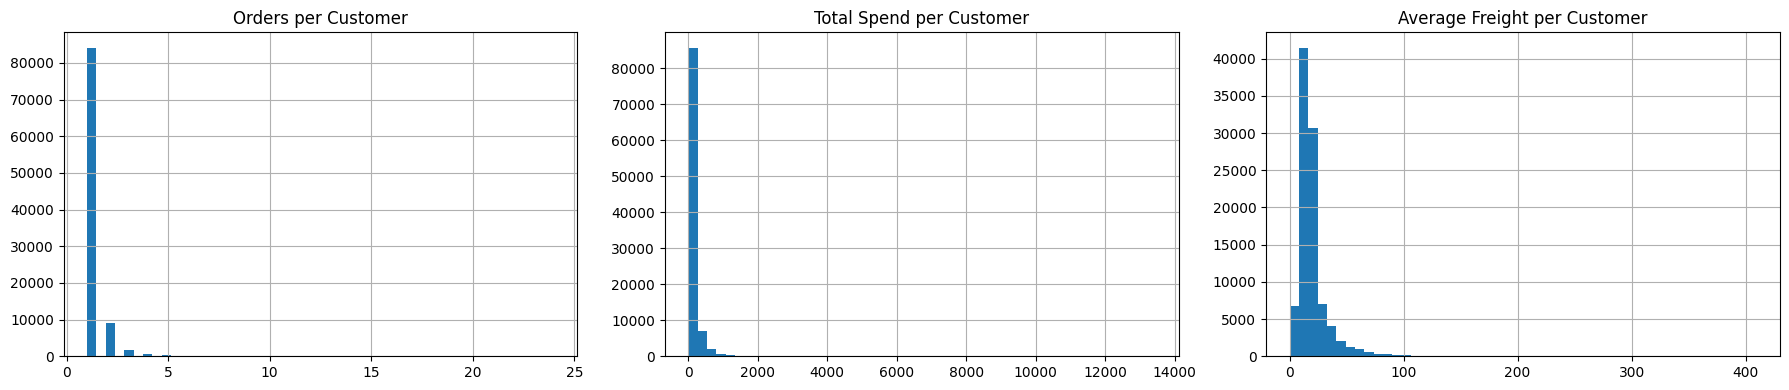

In [54]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

customer_data["num_orders"].hist(bins=50, ax=axes[0])
axes[0].set_title("Orders per Customer")

customer_data["total_spend"].hist(bins=50, ax=axes[1])
axes[1].set_title("Total Spend per Customer")

customer_data["avg_freight"].hist(bins=50, ax=axes[2])
axes[2].set_title("Average Freight per Customer")

plt.tight_layout()
plt.show()
# he we check how our aggragation performed 

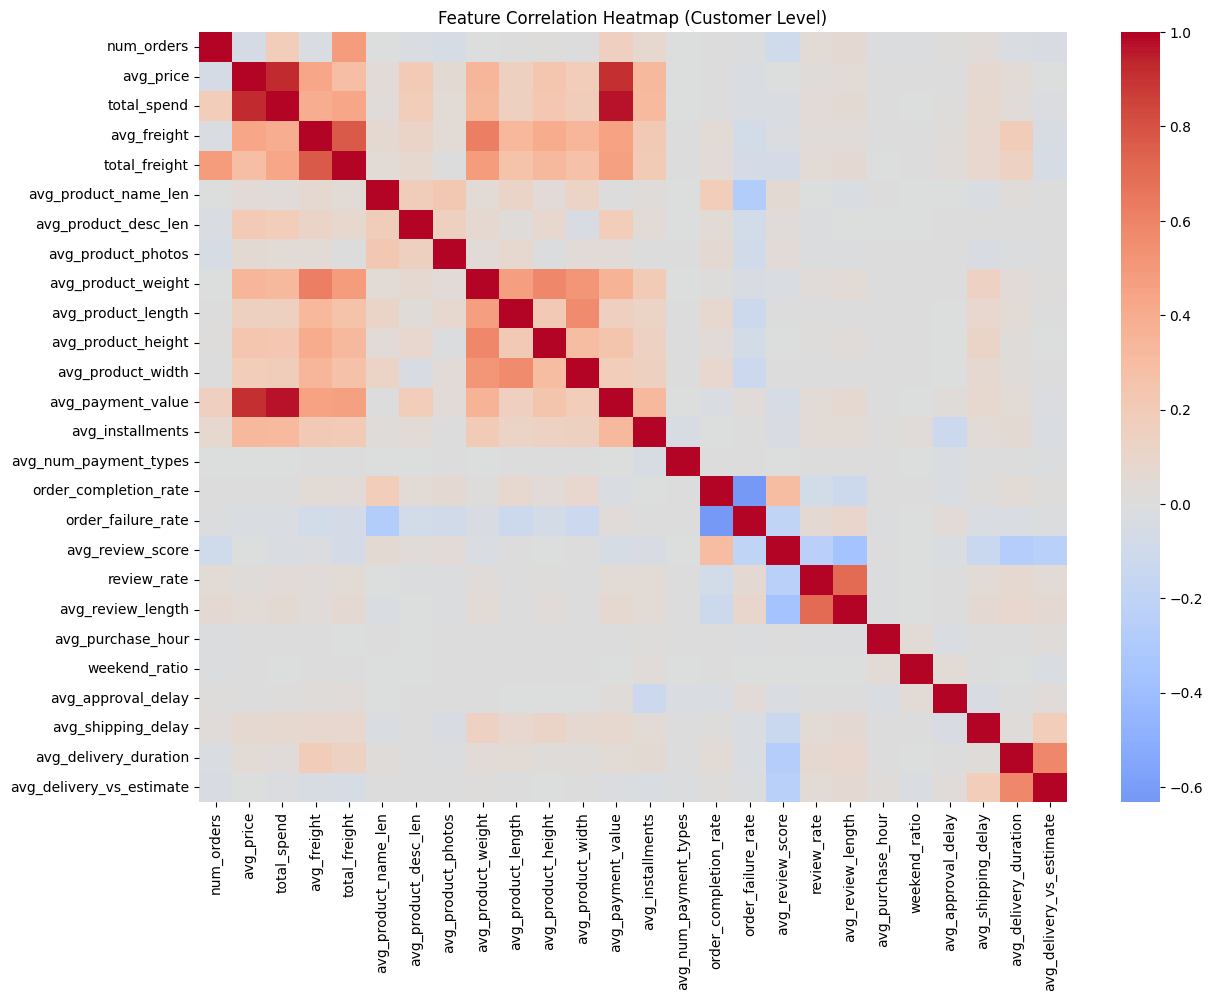

In [55]:
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(
    customer_data.drop(columns=["customer_unique_id"]).corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Feature Correlation Heatmap (Customer Level)")
plt.show()

In [18]:
"""WHY Calculate these becos we want a broad view of the dataset clearly most custmers placed only one 
to two orders  reamining also placed lesss than 5 so its not a good store people dont go back retentention rate 
bad 
also very less peolple spend gud money freight is pretty balnced compared to other (comparitively)

"""

In [ ]:
"""WHY HEATMAP

The correlation heatmap reveals clear behavioral blocks 
corresponding to economic value, product preferences, 
logistics friction, and engagement patterns. The presence 
of structured correlations validates the use of PCA to compress 
redundant information while
preserving meaningful customer-level variation.

"""
# so what next obviously its pca even though my column num is less here the main reson for using pca is 
# to remove redunant features and make the featuure space simple for interpretataion the mixture 
# of dark and light colurs in heat map ensure the its the right thing to do 


In [56]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca_full = pca.fit_transform(customer_data_scaled)
explained_variance = pca.explained_variance_ratio_

explained_variance_df = pd.DataFrame({
    "PC": np.arange(1, len(explained_variance) + 1),
    "Explained_Variance_Ratio": explained_variance,
    "Cumulative_Variance": np.cumsum(explained_variance)
})

explained_variance_df.head(10)



,PC,Explained_Variance_Ratio,Cumulative_Variance
0,1,0.175824,0.175824
1,2,0.089147,0.264970
2,3,0.075540,0.340511
3,4,0.064448,0.404958
4,5,0.057527,0.462485
5,6,0.051428,0.513913
6,7,0.045109,0.559023
7,8,0.041302,0.600324
8,9,0.040298,0.640623
9,10,0.038954,0.679576


In [57]:
# Feature selection reduces dimensionality in feature space; 
#PCA reduces dimensionality in variance space.

In [58]:
# PCA is a linear algebra tool, not a feature engineering tool 
# so here lets plot the curve and decide what to do with data shud it be with pca or without pca 
# as with pca it gud with regression and not with decision trees but it a unsupervised model 
# so we must take a cautious step or just evaluate the model on both and report the best one 
X_pca_full.shape

(96096, 26)

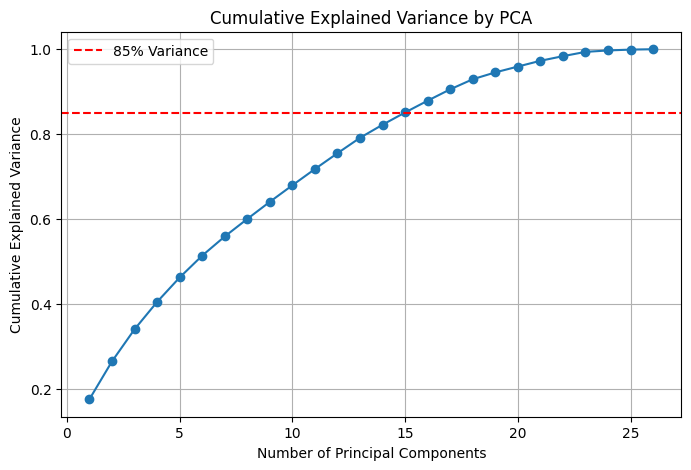

In [59]:
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(
    np.arange(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o'
)
plt.axhline(y=0.85, color='r', linestyle='--', label="85% Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by PCA")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# so ya 15 components represnting 85 percent of data now lets export
#all the data we have and train on all these 
# and report the best one 
customer_data_scaled.to_csv("customer_aggregated_features.csv", index=False)
data.to_csv("final_processed_data_bef_ca.csv",index=False)

In [61]:
X_pca_df = pd.DataFrame(
    X_pca_full,
    columns=[f"PC{i}" for i in range(1, X_pca_full.shape[1] + 1)]
)
X_pca_df.to_csv("pca_processed_aft_ca.csv", index=False)